### Vector embedding and storing in database

In [60]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import psycopg2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re

/home/harsh/myenv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [62]:


# Download NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

data = pd.read_csv("chatbot-combined.csv")

# def clean_text(text):
#     # Remove special characters and numbers
#     text = re.sub(r"[^a-zA-Z\s]", "", text)
#     # Convert text to lowercase
#     text = text.lower()
#     # Tokenize and remove stopwords
#     tokens = word_tokenize(text)
#     filtered_tokens = [word for word in tokens if word not in stop_words]
#     return " ".join(filtered_tokens)

# # Apply cleaning to questions and answers
# data['cleaned_question'] = data['question'].apply(clean_text)
# data['cleaned_answer'] = data['answer'].apply(clean_text)



# Load a model for generating embeddings
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

# Generate embeddings for cleaned questions
data['embedding'] = data['question'].apply(lambda x: model.encode(x).tolist())


[nltk_data] Downloading package punkt_tab to /home/harsh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/harsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
data

,question,answer,embedding
0,What is the fees?,Sitare University is committed to providing hi...,"[0.03795766830444336, -0.21311859786510468, -0..."
1,What is the cost of education?,Sitare University is committed to providing hi...,"[0.3566315174102783, -0.16345636546611786, 0.2..."
2,What is the curriculum?,The curriculum at Sitare University focuses on...,"[0.2271815985441208, 0.3732479512691498, -0.31..."
3,How are the faculty?,Sitare University has very high standards for ...,"[0.07059022784233093, -0.037369679659605026, 0..."
4,How many faculty are there?,"As of 2024, we have more than 8 full time facu...","[0.5160751342773438, -0.42770346999168396, 0.4..."
...,...,...,...
245,Is it better than nits and iiits,We strongly believe that Sitare University is ...,"[-0.6393411159515381, -0.030787663534283638, 0..."
246,Why SU is best over private collages?,We strongly believe that Sitare University is ...,"[-0.18775711953639984, -0.1767575889825821, -0..."
247,How many clubs are there?,There are total 7 clubs as follows: Coding clu...,"[1.0068161487579346, -0.6270226836204529, 0.06..."
248,Which clubs are there?,There are total 7 clubs as follows: Coding clu...,"[1.0625401735305786, -0.7726207375526428, -0.1..."


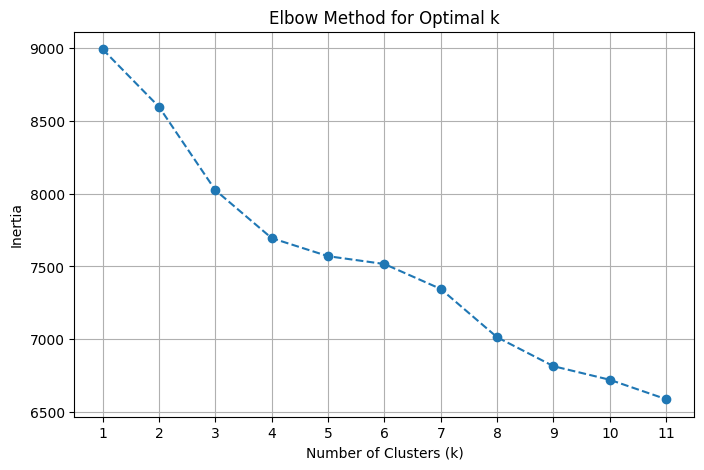

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import psycopg2

embeddings = np.array([np.array(row) for row in data['embedding']]) 
# Range of possible cluster numbers to test
k_values = range(1, 12)  # You can adjust the upper limit as needed
inertia = []

# Calculate inertia for each number of clusters
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()


In [ ]:
import psycopg2
from psycopg2.extras import execute_values
from sklearn.cluster import KMeans
import numpy as np

# Define the number of clusters (optimal_k) based on the elbow method
optimal_k = 4

# Step 1: Run K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)
cluster_assignments = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Step 2: Database Connection
conn = psycopg2.connect(
    host="localhost",
    database="mldb",
    user="postgres",
    port="5432",
    password="Harsh@517"
)
cur = conn.cursor()

# Step 3: Create Table with pgVector Data Types
create_table_query = """
CREATE TABLE IF NOT EXISTS qa_embeddings (
    cluster INTEGER,
    center vector,
    embeddings vector[],
    answer TEXT[],
    question TEXT[]
);
"""
cur.execute(create_table_query)
conn.commit()

# Ensure data is in numpy array format
answer = np.array(data['answer'])
question = np.array(data['question'])
embedding = np.array(data['embedding'])

In [137]:
import psycopg2
import numpy as np

# Step 4: Prepare Data for Insertion
data_to_insert = []
for cluster_id in range(optimal_k):
    # Collect embeddings and answers for the current cluster
    embeddings_in_cluster = embedding[cluster_assignments == cluster_id]
    answers_in_cluster = answer[cluster_assignments == cluster_id].tolist()
    questions_in_cluster = question[cluster_assignments == cluster_id].tolist()

    center_of_cluster = cluster_centers[cluster_id]

    # Convert embeddings and center to strings in pgvector format
    center_pg_format = f"[{', '.join(map(str, map(float, center_of_cluster)))}]"
    embeddings_pg_format = [
        f"[{', '.join(map(str, map(float, embedding)))}]"
        for embedding in embeddings_in_cluster
    ]

    # Prepare each row for insertion
    for emb, ans, quest in zip(embeddings_pg_format, answers_in_cluster, questions_in_cluster):
        data_to_insert.append((
            cluster_id,
            center_pg_format,  # Cluster center as vector (bracketed, comma-separated)
            emb,  # Single embedding as vector (bracketed, comma-separated)
            [ans],  # Single answer as list
            [quest]  # Single question as list
        ))

# Modified insert query
insert_query = """
INSERT INTO qa_embeddings (
    cluster, 
    center, 
    embeddings, 
    answer, 
    question
) VALUES (
    %s, 
    %s::vector, 
    ARRAY[%s]::vector[], 
    %s, 
    %s
);
"""

# Manual insertion with cursor
try:
    for item in data_to_insert:
        cur.execute(insert_query, (item[0], item[1], item[2], item[3], item[4]))
except Exception as e:
    print(f"An error occurred: {e}")
    conn.rollback()
else:
    # Commit if no errors
    conn.commit()

# Close connection
cur.close()
conn.close()

print("Clustered data inserted into the database successfully.")


Clustered data inserted into the database successfully.


In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sentence_transformers import SentenceTransformer
import psycopg2
from ast import literal_eval

# Database connection
conn = psycopg2.connect(
    host="localhost",
    database="mldb",
    user="postgres",
    port="5432",
    password="Harsh@517"
)
cur = conn.cursor()

# Load model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

user_question = "Campus of the University"
user_embedding = model.encode([user_question])  # 2D array

# Convert user_embedding to a PostgreSQL-compatible vector string
user_vector = "[" + ",".join(map(str, user_embedding.tolist()[0])) + "]"

# SQL query to fetch answers with vector arrays
query = """
    WITH closest_center_row AS (
    SELECT *
    FROM qa_embeddings
    ORDER BY center <-> %s::vector
    LIMIT 1
),
distances AS (
    SELECT 
        c.cluster,
        c.question,
        c.answer,
        c.center,
        u.idx AS embedding_index,
        u.vector AS embedding_vector,
        u.vector <-> %s::vector AS distance
    FROM closest_center_row c,
    UNNEST(c.embeddings) WITH ORDINALITY AS u(vector, idx)
)
SELECT 
    d.cluster,
    d.question,
    d.embedding_vector AS closest_embedding,
    d.distance AS closest_distance,
    d.embedding_index AS closest_index,
    d.answer[d.embedding_index] AS closest_answer
FROM distances d
ORDER BY d.distance
LIMIT 1;
"""

# Execute query with the formatted vector
cur.execute(query, (user_vector, user_vector))
response = cur.fetchone()

# Close connection
cur.close()
conn.close()

print(response)


(1, ['What is the curriculum?'], '[0.2271816,0.37324795,-0.3164809,-0.29089186,0.09376414,0.091678314,-0.5285208,-0.026453054,-0.14548406,0.5262798,0.14082566,-0.17962421,-0.017037993,0.37736246,-0.07068442,-0.5463092,0.59791833,-0.24898537,0.120049976,-0.602286,-0.040383223,0.39388362,0.092473745,0.23141532,0.3319194,0.26730934,-0.31002954,-0.37305927,0.028012726,-0.25061396,-0.39363906,0.035910916,0.6849576,0.27639654,-0.54344356,0.6993,0.8178728,-0.02432155,-0.4051856,0.30616346,-0.50281394,0.028879557,-0.32610744,0.3379697,0.108683266,-0.7347892,-0.46392742,-0.31253988,-0.31076774,-0.08816082,-0.42183214,-0.17209753,-0.27033576,0.40717405,-0.09708921,0.6787191,0.9064097,0.039482266,-0.35446692,-0.0812472,-0.86572987,0.09363216,-0.08387867,1.0104905,0.22379972,0.13701795,0.17732818,0.68535244,0.08060861,-0.31851965,-0.4646051,-0.6424312,0.4733153,0.42809358,0.30620438,-0.22931525,0.06027334,0.21069336,0.3243092,-0.5987253,0.34512827,-0.044519763,-0.08530559,-0.15756094,0.41011527,0.

In [15]:
print("Embeddings Array Type:", type(embeddings_array))
print("Embeddings Array First Element Type:", type(embeddings_array[0]))
print("Embeddings Array First Element:", embeddings_array[0])

Embeddings Array Type: <class 'str'>
Embeddings Array First Element Type: <class 'str'>
Embeddings Array First Element: {


In [20]:
conn = psycopg2.connect(
    host="localhost",
    database="mldb",
    user="postgres",
    port="5432",
    password="Harsh@517"
)
cur = conn.cursor()

# Load model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Input question
user_question = "What is Sitare University?"
user_embedding = model.encode([user_question]).flatten().tolist()

# SQL query to find the closest cluster center
query = """
    SELECT answer, embeddings, center
    FROM qa_embeddings
    ORDER BY center <-> %s::vector
    LIMIT 1;
"""
cur.execute(query, (user_embedding,))
response = cur.fetchone()

a,b,c = response
print(c)
cur.close()
conn.close()




[0.25476268,-0.1827917,0.07048238,0.11276816,-0.30393425,0.34882796,-0.5261309,0.14399248,-0.048202466,0.31542838,-0.027007086,-0.0744473,0.08024129,-0.041914243,0.054681417,-0.34470683,-0.16888355,-0.07320572,0.3219266,0.032471236,-0.22048607,0.056560386,-0.29872143,-0.15450379,0.53576744,0.0015608816,0.10529755,-0.17949416,0.1439882,-0.24199305,-0.07561963,-0.10737139,0.21646371,0.07176756,0.21064024,0.24146432,0.03366471,-0.22280459,-0.4775305,0.13091786,-0.19543181,-0.16164254,0.039044525,0.13329822,0.05153679,-0.325422,-0.12711456,-0.37491655,-0.022180036,0.37059134,-0.372863,0.04776236,0.08319165,0.20613222,-0.17989878,-0.057169557,0.2319098,0.124677114,-0.05449606,-0.13774726,-0.12144216,-0.25418118,-0.07457301,0.17471105,0.3818862,0.010693012,0.06480535,0.012538763,0.050542403,0.114079885,-0.3781851,-0.28941816,0.40947044,-0.11826193,0.19857962,0.27226788,-0.23256521,0.06256194,0.5357014,-0.16401406,0.2156203,0.19699387,-0.20318703,0.26096508,0.2095258,-0.08834848,-0.13285387,-